# Hospital Stay Predictions

This notebook uses hospital patient records to predict the length of a patients stay at time of admission. It is possible to have multiple records per patient

The notebook is layed out as follows:

1. Data Exploration & Preparation
2. Diagnostic analysis
3. Predictive analysis

In [587]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder
import category_encoders as ce
from helpers.plots import *
import os
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import StandardScaler

## 1. Data Exploration & Preparation

In this section the data set is cleaned and its format prepared for processing.

* Load data

In [588]:
# Get data path
DIR = os.getcwd() # current working directory
DATA_PATH = os.path.join(DIR,"data","hospital_stay_data.csv")

# Load data
df = pd.read_csv(DATA_PATH)

* Data Preview

In [589]:
# Store number of record in raw data
num_records = df.shape[0]

# Preview data set
print(f"Number of Features: {df.shape[1]}")
print(f"Number of Records : {num_records}")
print("Data preview: \n")
df.head()

Number of Features: 18
Number of Records : 318438
Data preview: 



,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [590]:
# View spread and range of numeric data
df.describe()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000
mean,159219.500000,18.318841,4.771717,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392
std,91925.276848,8.633755,3.102535,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,79610.250000,11.000000,2.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000
50%,159219.500000,19.000000,5.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000
75%,238828.750000,26.000000,7.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000
max,318438.000000,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000


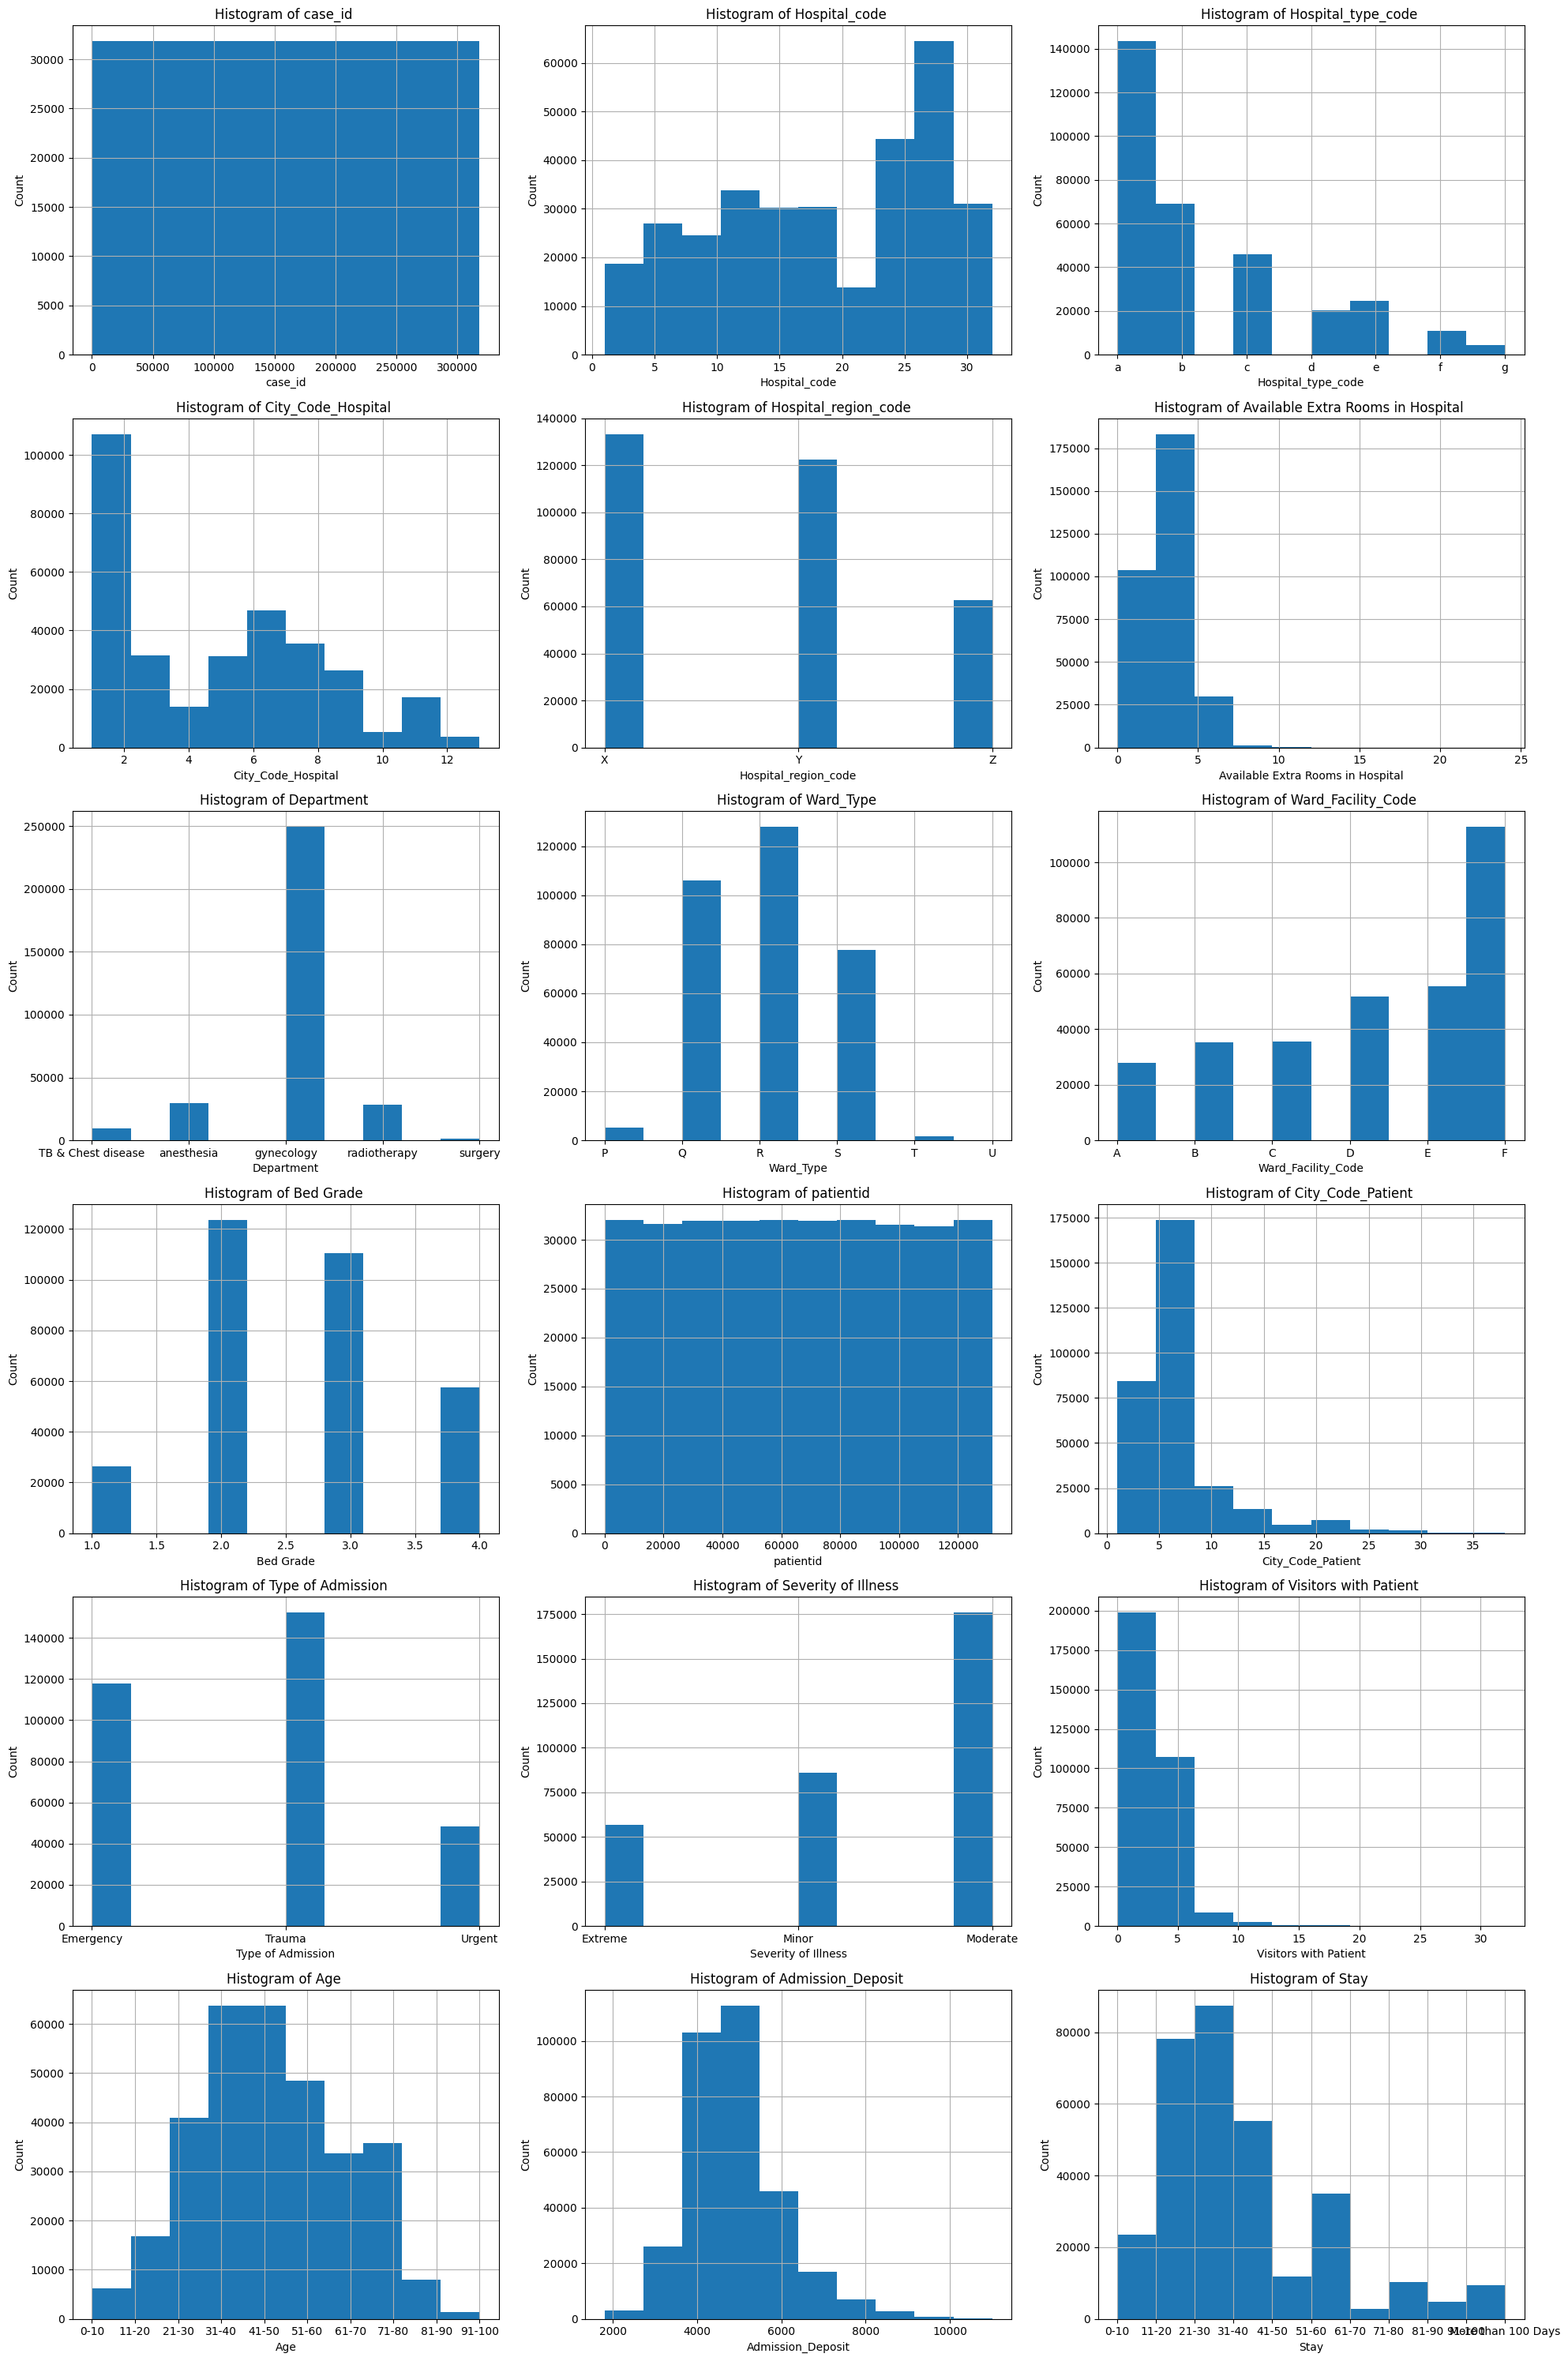

In [591]:
# View histogram of features
plot_histograms(df, 3)

* Look for patterns between feature categories and target "Stay"

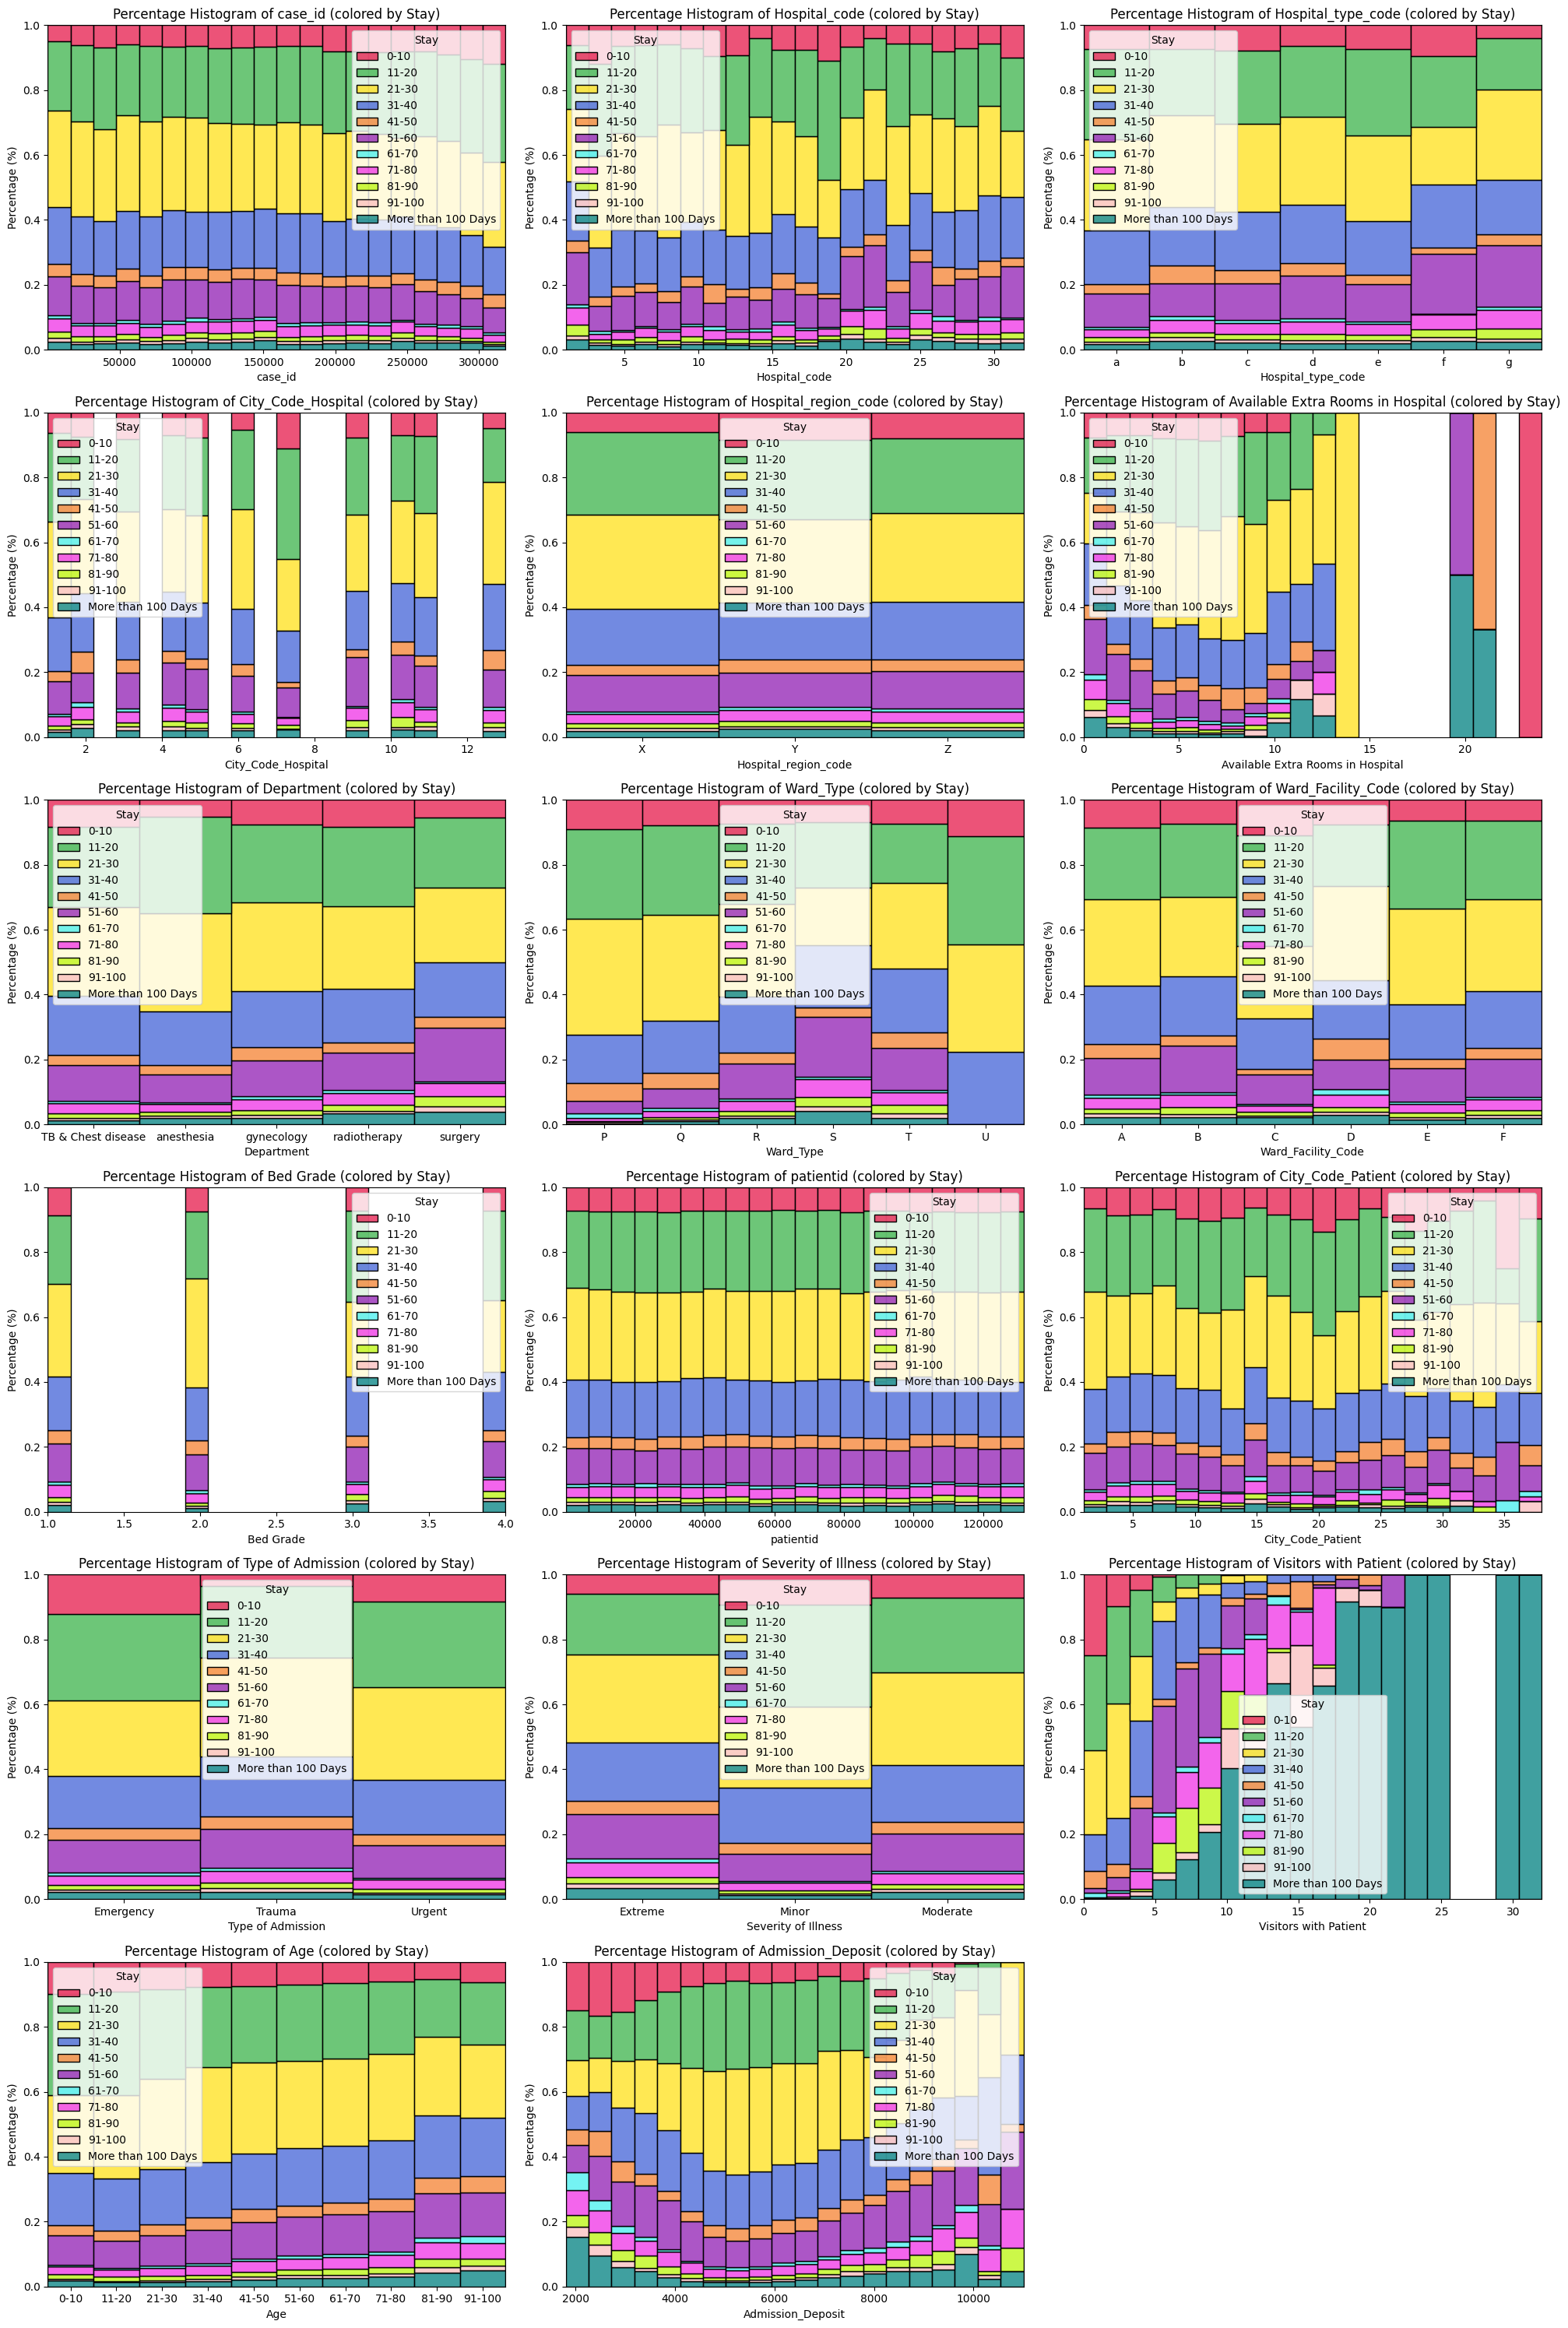

In [592]:
# View histogram of data by percentage makeup of target class
target = "Stay"
n_cols = 3
feature_columns = [col for col in df.columns if col != target]
num_features = len(feature_columns)

# Determine number of rows needed
num_rows = (num_features + n_cols - 1) // n_cols

fig, axs = plt.subplots(num_rows, n_cols, figsize=(20, num_rows * 5))
axs = axs.flatten()

# Plot each feature column
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#000000']
for i, column in enumerate(feature_columns):
    df = df.sort_values(by=[target,column]) # Sort dataframe
    
    # Compute histogram with percentages
    sns.histplot(data=df, x=column, hue=target, ax=axs[i], bins=20,
                    multiple="fill", kde=False, stat="percent", palette=sns.color_palette(colors, n_colors=df[target].nunique()))
    
    axs[i].set_title(f"Percentage Histogram of {column} (colored by {target})")
    axs[i].set_ylabel("Percentage (%)")
    axs[i].set_xlabel(column)

# Hide extra subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
    

#### Data Cleaning & Handling Missing Data

* Create lists to sort features into categories based on their type 

In [593]:
# Create lists based on column types
drop_cols = ["patientid", "case_id"] # columns to remove 
cont_cols = ["Admission_Deposit"] # columns with continuous vars
int_cols  = ["Available Extra Rooms in Hospital", "Visitors with Patient"] # columns with integer vars
ord_cols  = ["Severity of Illness", "Age", "Stay", "Type of Admission","Bed Grade", "City_Code_Patient"] # columns with ordinal categorical vars
nom_cols  = ["Hospital_code", "Hospital_type_code", "City_Code_Hospital", "Hospital_region_code", "Department", "Ward_Type", "Ward_Facility_Code"] # columns with nominal categorical vars --> dummy encoding (ensure not too many categories)

* Check for missing data

In [594]:
# Check for Nan values 
print("Columns containing Nan values: ", [i for i in df.columns if df[i].isna().any()])

Columns containing Nan values:  ['Bed Grade', 'City_Code_Patient']


* Impute patient's city code using other records when possible, then remove remaining rows with empty data

In [595]:
# Fill City_Code_Patient using another existing record for that patient
City_Code_Patient_dict = df[["patientid","City_Code_Patient"]].dropna().drop_duplicates(inplace=False).set_index("patientid").to_dict() # dict of patient id and their city codes

for i in range(df.shape[0]): # for each row of data
    if np.isnan(df.iloc[i]["City_Code_Patient"]) and df.iloc[i]["patientid"] in City_Code_Patient_dict.keys(): #if the city code is missing and their is another patient record to fill from
        df.iloc[i]["City_Code_Patient"] = City_Code_Patient_dict[df.iloc[i]["patientid"]]


# Drop records with empty values and unnecessary columns
df_clean = df.copy()
df_clean.dropna(inplace=True)
df_clean.drop(drop_cols,axis=1, inplace=True)
print("Columns containing Nan values: ", [i for i in df_clean.columns if df_clean[i].isna().any()])  

Columns containing Nan values:  []


* Check data loss

In [596]:
# Assess data loss due to cleaning
print(f"After cleaning {round(df_clean.shape[0]*100/num_records,1)}% of the data remains")

After cleaning 98.5% of the data remains


#### Data Encoding - Ordinal


In [597]:
# Check number of unique categories
print("Ordinal features and their cardinality")
for ord in ord_cols:
    print("\t -",ord, df[ord].nunique())

Ordinal features and their cardinality
	 - Severity of Illness 3
	 - Age 10
	 - Stay 11
	 - Type of Admission 3
	 - Bed Grade 4
	 - City_Code_Patient 37


In [598]:
# Encode severity of illness
sev_mapping = {'Minor':0, 'Moderate':1, 'Extreme':2} #set ordering
df_clean["Severity of Illness"] = df_clean["Severity of Illness"].replace(sev_mapping)


# Type of Admission
admiss_mapping = {'Trauma':0, 'Urgent':1, 'Emergency':2} #set ordering
df_clean["Type of Admission"] = df_clean["Type of Admission"].replace(admiss_mapping)
    
# Encode other ordinal vars
enc = LabelEncoder()
for ord in ord_cols:
    if ord in ["Type of Admission", "Severity of Illness"]:
        continue
    if ord =='Stay':
        stay_enc = enc
    df_clean[ord] = enc.fit_transform(df_clean[ord])

# Print encodings 
df_clean[ord_cols]

C:\Users\sian_\AppData\Local\Temp\ipykernel_19896\2427298102.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean["Severity of Illness"] = df_clean["Severity of Illness"].replace(sev_mapping)
C:\Users\sian_\AppData\Local\Temp\ipykernel_19896\2427298102.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean["Type of Admission"] = df_clean["Type of Admission"].replace(admiss_mapping)


,Severity of Illness,Age,Stay,Type of Admission,Bed Grade,City_Code_Patient
314370,1,4,0,0,2,5
289417,2,4,0,2,0,3
110589,2,4,0,2,1,15
84490,0,7,0,2,3,7
276643,2,3,0,1,0,7
...,...,...,...,...,...,...
122695,1,2,10,0,2,0
97504,2,6,10,0,3,6
106828,1,4,10,1,3,5
73391,1,9,10,0,1,4


#### Ensure correct data types

In [599]:
# Correct variable types
for col in cont_cols:
    df_clean[col] = df_clean[col].astype(float) #ensure continuous vars are floats 
for col in int_cols+ord_cols:
    df_clean[col] = df_clean[col].astype(int) #ensure continuous vars are floats 
# for col in nom_cols:
#     df_clean[col] = df_clean[col].astype(str) #ensure nominal vars are strings
    
df_clean.dtypes

Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                              int64
City_Code_Patient                      int64
Type of Admission                      int64
Severity of Illness                    int64
Visitors with Patient                  int64
Age                                    int64
Admission_Deposit                    float64
Stay                                   int64
dtype: object

#### Cardinality of Nominal Features

In [600]:
print("Nominal features and their cardinality")
for nom in nom_cols:
    print("\t -",nom, df_clean[nom].nunique())

Nominal features and their cardinality
	 - Hospital_code 32
	 - Hospital_type_code 7
	 - City_Code_Hospital 11
	 - Hospital_region_code 3
	 - Department 5
	 - Ward_Type 6
	 - Ward_Facility_Code 6


## 2. Diagnostic Analysis

#### Feature Relationship Analysis

1. **Kendall's Tau Correlation**
is used as it can assess the relationship between the features and the target variable "Stay". The null hypothesis assumes that there is no monotonic relationship between the two variables. It was chosen because:
    - does not assume normally distributed data ( is non-parametric)
    - less sensitive to tied ranks 
    - assumptions:
        - ordinal or continuous data
        - monotonic relationship between variables (not strict)

1. **Cramer's V**
is used to determine the strength of relationship between 2 categorical variables. It uses the Chi^2 statistic to produce a normalised coeffecient in (0,1) which allows for comparison across the entrie table.
    - applicable to tables  bigger than 2x2
    - assumptions:
        - categorical data
        - mutually exclusive levels or categories
        - frequency in each cell is at least 5 in 80% of cells
The Chi^2 statistic tests for independence of two categories.


In both cases alpha = 0.05

#### Integer, Continuous & Ordinal Correlation

* Compute rank correlation

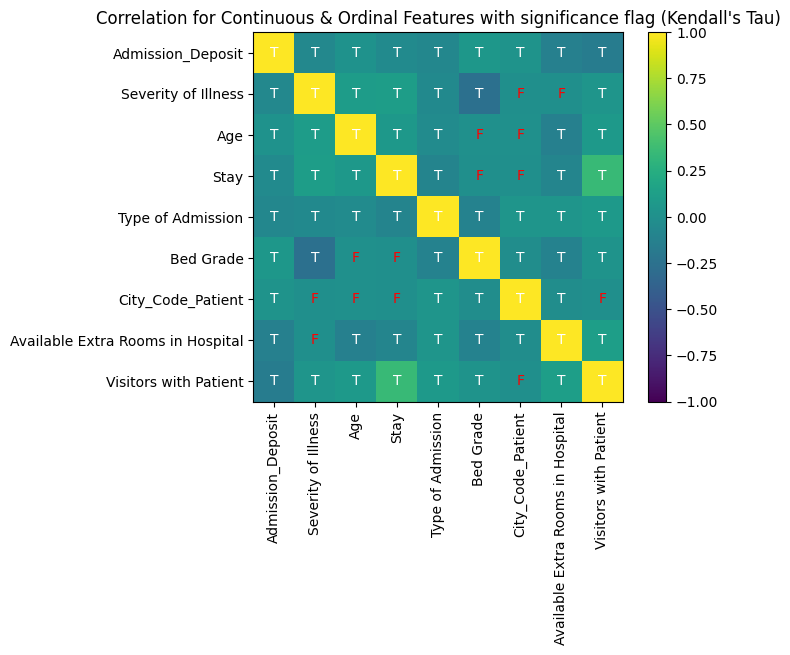

Features to remove:  ['Bed Grade', 'City_Code_Patient']


In [601]:
# Define alpha
alpha = 0.05

# Compute Kendall's Tau Correlation 
kendall_cols = cont_cols + ord_cols + int_cols
kendalls_corr = pd.DataFrame(index=kendall_cols, columns=kendall_cols)          # to store corr
significance_matrix = pd.DataFrame(index=kendall_cols, columns=kendall_cols)    # to store p_value

for col1 in kendall_cols:
    for col2 in kendall_cols:
        tau, p_value = stats.kendalltau(df_clean[col1], df_clean[col2])
        kendalls_corr.loc[col1, col2] = tau
        significance_matrix.loc[col1, col2] = p_value

# Plot correlation as heatmap
plt.imshow(kendalls_corr.astype(float), vmin=-1, vmax=1, cmap='viridis')
plt.colorbar()
plt.xticks(range(len(kendall_cols)),labels=kendall_cols, rotation=90)
plt.yticks(range(len(kendall_cols)),labels=kendall_cols, rotation=0)
plt.title("Correlation for Continuous & Ordinal Features with significance flag (Kendall's Tau)")

# Overlay the significance of correlation as text
to_drop = []
for i,col1 in enumerate(kendall_cols):
    for j,col2 in enumerate(kendall_cols):
        sig = significance_matrix.loc[col1, col2] # get significance
    
        # Annotate the significance text in the heatmap
        if sig <= alpha/2: # divide alpha by two since a two tail test was used
            plt.text(j, i, "T", ha='center', va='center', color='white', fontsize=10)
        else:
            plt.text(j, i, "F", ha='center', va='center', color='red', fontsize=10)
            if col1 == "Stay":
                to_drop +=[col2]

# show plot
plt.show()
print("Features to remove: ", to_drop)

The results show that:
* "Visitors with Patient" is the best indicator for the target variable "Stay". 
* most features show a relatively weak positive relationship with the target variable "Stay"
* there is some weak correlation between features
* the "Bed Grade" and "City_Code_Patient" features does not have a significant relationship with the target variable "Stay" and should be removed

In [602]:
print("Absolute Kendall's tau values for significant features and Stay")
print()
print(kendalls_corr.drop(to_drop)["Stay"].abs().sort_values(ascending=False))

Absolute Kendall's tau values for significant features and Stay

Stay                                      1.0
Visitors with Patient                0.349825
Severity of Illness                  0.110118
Type of Admission                    0.099086
Available Extra Rooms in Hospital    0.089261
Age                                  0.069873
Admission_Deposit                    0.040775
Name: Stay, dtype: object


#### Nominal Features

* Determine the features which have a statistically significant impact on the target (Stay)

In [603]:
# Check frequency at least 5 for nominal columns
count = 0
for col in nom_cols+["Stay"]:
    value_counts = df[col].value_counts() # get count of each value
    
    # Check if count less than 5
    if any(value_counts < 5):
        count += 1
        
assert count==0 # All categories have a frequency of at least 5, thus Chi squared and Cramers V can be used    

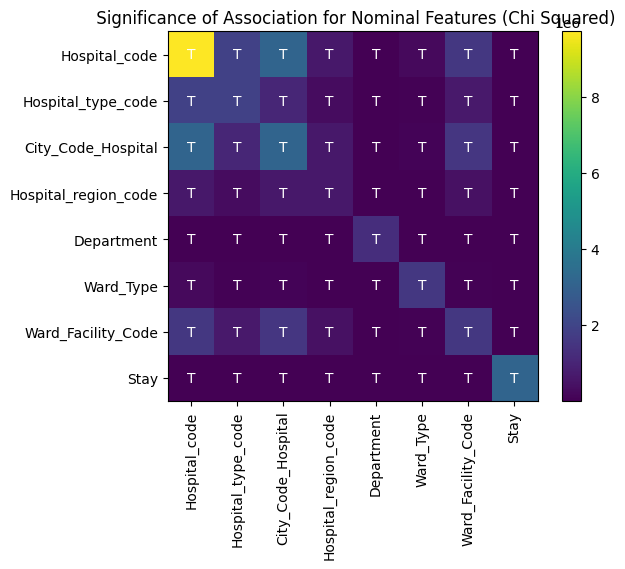

Features to remove:  ['Bed Grade', 'City_Code_Patient']


In [604]:
#Chi-Squared statistic for nominal variables
chi2_matrix   = pd.DataFrame(index=nom_cols, columns=nom_cols)          # to store chi^2 val
chi2_sig_matrix = pd.DataFrame(index=nom_cols, columns=nom_cols)        # to store p_value
chi2_dof_matrix = pd.DataFrame(index=nom_cols, columns=nom_cols)        # to store p_value

for col1 in nom_cols+["Stay"]:
    for col2 in nom_cols+["Stay"]:
        ## Construct contingency table between target and each categorical var
        contingency_table = pd.crosstab(df_clean[col1],df_clean[col2])
        
        ## Calculate Chi-squared  statistic
        chi2, p_value, dof, E = stats.chi2_contingency(contingency_table)
        chi2_matrix.loc[col1, col2] = chi2
        chi2_sig_matrix.loc[col1, col2] = p_value
        chi2_dof_matrix.loc[col1, col2] = dof
          
# Plot association as heatmap
plt.imshow(chi2_matrix.astype(float), cmap='viridis')
plt.colorbar()
plt.xticks(range(len(nom_cols+["Stay"])),labels=nom_cols+["Stay"], rotation=90)
plt.yticks(range(len(nom_cols+["Stay"])),labels=nom_cols+["Stay"], rotation=0)
plt.title(" Significance of Association for Nominal Features (Chi Squared)")

# Overlay the significance of association as text
for i,col1 in enumerate(nom_cols+["Stay"]):
    for j,col2 in enumerate(nom_cols+["Stay"]):
        sig = chi2_sig_matrix.loc[col1, col2] # get significance
    
        # Annotate the significance text in the heatmap
        if sig <= alpha:
            plt.text(j, i, "T", ha='center', va='center', color='white', fontsize=10)
        else:
            plt.text(j, i, "F", ha='center', va='center', color='red', fontsize=10)
            if col1 == "Stay":
                to_drop +=[col2]

# Show plot
plt.show()
print("Features to remove: ", to_drop)

The results show that:
* All nominal features have a significant association with the target variable "Stay" and should be considered in the Cramer's V analysis
* There appears to be a weak association between the nominal features and "Stay"
* "Hospital Code" and "City_Code_Hospital" are very highly correlated, it may be useful to only keep "City_Code_Hospital" which has cardinality 11 as opposed to "Hospital Code" with 32

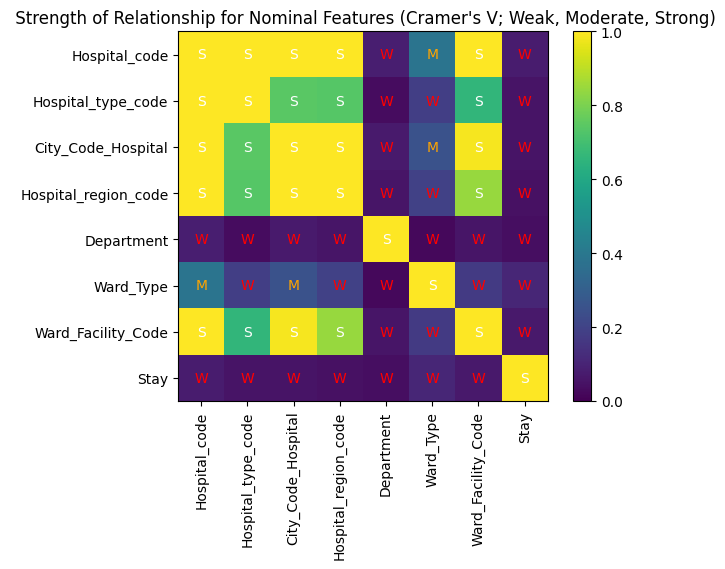

Features to remove:  ['Bed Grade', 'City_Code_Patient']


In [605]:
#Cramer's V for nominal variables
cramer_matrix   = pd.DataFrame(index=nom_cols+["Stay"], columns=nom_cols+["Stay"])          # to store Cramer's V
n = df_clean.shape[0]                                                                       # Sample size

for col1 in nom_cols+["Stay"]:
    for col2 in nom_cols+["Stay"]:
        contingency_table = pd.crosstab(df_clean[col1],df_clean[col2]) # Construct contingency table between target and each categorical var
        min_dim = min(contingency_table.shape) - 1                     # Minimum table dimension

        # Compute Cramer's V
        cramer_matrix.loc[col1, col2] = np.sqrt(chi2_matrix.loc[col1, col2].astype(float) / (n * min_dim))   
        # print( np.sqrt(chi2_matrix.loc[col1, col2] / (n * min_dim)) )
        # print( chi2_matrix.loc[col1, col2] / (n * min_dim))
        # print( chi2_matrix.loc[col1, col2])
        # print( (n * min_dim))
         
# Plot strength of relationship as heatmap
plt.imshow(cramer_matrix.astype(float), vmin=0, vmax=1, cmap='viridis')
plt.colorbar()
plt.xticks(range(len(nom_cols+["Stay"])),labels=nom_cols+["Stay"], rotation=90)
plt.yticks(range(len(nom_cols+["Stay"])),labels=nom_cols+["Stay"], rotation=0)
plt.title(" Strength of Relationship for Nominal Features (Cramer's V; Weak, Moderate, Strong)")

# Overlay the relationship value as text
for i,col1 in enumerate(nom_cols+["Stay"]):
    for j,col2 in enumerate(nom_cols+["Stay"]):
        sig = cramer_matrix.loc[col1, col2] # get significance
    
        # Annotate the heatmap
        if sig <= 0.2: # Weak assosiation
            plt.text(j, i, "W", ha='center', va='center', color='red', fontsize=10)
        elif sig <=0.6:
            plt.text(j, i, "M", ha='center', va='center', color='orange', fontsize=10)
        else:
            plt.text(j, i, "S", ha='center', va='center', color='white', fontsize=10)
            

# show plot
plt.show()
print("Features to remove: ", to_drop)

From using Cramer's V to compare the relationships of the nominal features, we see:
* "Ward_Type" has the strongest associations to "Stay", even though the relationship is still weak.
* There are many strong relationships between the nominal features which each have different numbers of unique categories. One of these features should be selected and the others removed. High dimensional encoded data leads to sparsity and can make classfification harder. Also, highly correlated features add unnecessary redundancies, and can make it harder for models to distinguish the effects of individual features. 
    *  "Hospital_code" (cardinality: 32) is very strongly related to "Ward_Facility_Code" (6), "City_Code_Hospital" (11), "Hospital_type_code" (7), "Hospital_Region_Code" (3)


In [606]:
print("Cramer's V for significant features and Stay")
print()
print(cramer_matrix["Stay"].sort_values(ascending=False))

print()
print("Cramer's V for significant features and Hospital_code ")
print()
print(cramer_matrix["Hospital_code"].sort_values(ascending=False))

print()
print("Cramer's V for significant features and Ward_Facility_Code ")
print()
print(cramer_matrix["Ward_Facility_Code"].sort_values(ascending=False))

Cramer's V for significant features and Stay

Stay                         1.0
Ward_Type               0.107941
Hospital_code           0.075279
Ward_Facility_Code      0.068839
Hospital_type_code      0.054004
City_Code_Hospital      0.051731
Hospital_region_code    0.044036
Department              0.035476
Name: Stay, dtype: object

Cramer's V for significant features and Hospital_code 

Hospital_code                1.0
Hospital_type_code           1.0
City_Code_Hospital           1.0
Hospital_region_code         1.0
Ward_Facility_Code           1.0
Ward_Type               0.385376
Department              0.083847
Stay                    0.075279
Name: Hospital_code, dtype: object

Cramer's V for significant features and Ward_Facility_Code 

Hospital_code                1.0
Ward_Facility_Code           1.0
City_Code_Hospital      0.985432
Hospital_region_code    0.847207
Hospital_type_code      0.657622
Ward_Type                0.17001
Stay                    0.068839
Department     

#### Feature Selection

Looking at the Cramer's V results for nominal features:


Hospital code is the 3rd best feature but has a very high cardinality, however is very strongly related to the "Ward_Facility_Code". Using this features can:
* reduce dimensionality 
    * removing other highly correlated variables ("City_Code_Hospital", "Hospital_region_code", "Hospital_type_code")
    * by using 6 nominal categories instead of 32 if Hospital code is used
* selecting this feature instead of Hospital code leads to a weaker relationship with the "Ward_Type" features than Hospital_code 
    * this reduce redundancy, and improves generalisability of the model as models can more easily determine the impact of individual features.
    

In [607]:
print("Cramer's V for significant features and Stay after selecting most useful")
cramer_matrix.drop(["Hospital_code","City_Code_Hospital", "Hospital_region_code", "Hospital_type_code"])["Stay"].sort_values(ascending=False)

Cramer's V for significant features and Stay after selecting most useful


Stay                       1.0
Ward_Type             0.107941
Ward_Facility_Code    0.068839
Department            0.035476
Name: Stay, dtype: object

In [608]:
print("Absolute Kendall's tau values for significant features and Stay")
print()
print(kendalls_corr.drop(to_drop)["Stay"].abs().sort_values(ascending=False))

Absolute Kendall's tau values for significant features and Stay

Stay                                      1.0
Visitors with Patient                0.349825
Severity of Illness                  0.110118
Type of Admission                    0.099086
Available Extra Rooms in Hospital    0.089261
Age                                  0.069873
Admission_Deposit                    0.040775
Name: Stay, dtype: object


* Prepare data set for encoding nominal features

In [609]:
# Drop columns based on feature realtionship analysis
to_drop += ["Hospital_code","City_Code_Hospital", "Hospital_region_code", "Hospital_type_code"]
df_clean.drop(to_drop, axis=1, inplace=True)

#Tidy column names
df_clean.columns = df_clean.columns.str.strip().str.lower().str.replace(' ', '_')
df_clean.columns = df_clean.columns.str.replace('department', 'dpt')
df_clean.columns = df_clean.columns.str.replace('code', 'cd')
df_clean.columns = df_clean.columns.str.replace('of_', '')
df_clean.columns = df_clean.columns.str.replace('in_', '')
df_clean.columns = df_clean.columns.str.replace('extra_', '')
df_clean.columns = df_clean.columns.str.replace('available', 'avail')

# View columns of dataframe
print(list(df_clean.columns))

['avail_rooms_hospital', 'dpt', 'ward_type', 'ward_facility_cd', 'type_admission', 'severity_illness', 'visitors_with_patient', 'age', 'admission_deposit', 'stay']


* Check the appropriateness of bins using hierarchical clustering

In [610]:
# Use one hot encodings to represent nominal data
nom_cols = ['ward_type', 'ward_facility_cd', 'dpt']    
enc_cols =  pd.get_dummies(df_clean[nom_cols], columns=nom_cols)

(136,)


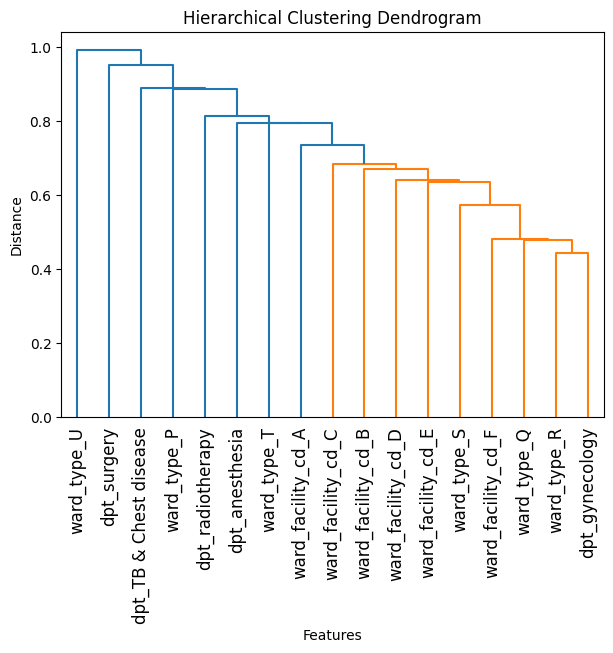

In [611]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute the pairwise distance
distance = pdist(enc_cols.T, metric='cosine') # cosine distance
print(distance.shape)
    
# Perform hierarchical clustering 
cluster = linkage(distance, method='single')

# Plot the dendrogram
plt.figure(figsize=(7, 5))
dendrogram(cluster, labels=enc_cols.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.show()

None of the encoded features groups are highly similar (on a distance scale from 0 to 1 between closest points in groups), so the current clusters are appropriate

* Update the dataframe with the one hot encodings of nominal data

In [612]:
# use binary encoding for nominal variables
be = BinaryEncoder(cols=nom_cols)
enc_cols = be.fit_transform(df_clean[nom_cols])

In [613]:
# Append encoded nominal data to dataframe
clean_shape = df_clean.shape # store shape of dataframe before alteration
df_clean = pd.concat([df_clean, enc_cols], axis=1,join='inner')
df_clean.drop(nom_cols, axis=1 ,inplace=True) 

# Check dimensions are correct
assert df_clean.shape[0] == clean_shape[0] #check rows
assert df_clean.shape[1] > clean_shape[1] #check cols

df_clean.head()


,avail_rooms_hospital,type_admission,severity_illness,visitors_with_patient,age,admission_deposit,stay,ward_type_0,ward_type_1,ward_type_2,ward_facility_cd_0,ward_facility_cd_1,ward_facility_cd_2,dpt_0,dpt_1,dpt_2
314370,6,0,1,6,4,1801.0,0,0,0,1,0,0,1,0,0,1
289417,3,2,2,2,4,1802.0,0,0,1,0,0,0,1,0,0,1
110589,7,2,2,5,4,1802.0,0,0,0,1,0,1,0,0,0,1
84490,2,2,0,2,7,1833.0,0,0,1,1,0,0,1,0,0,1
276643,4,1,2,2,3,1841.0,0,0,1,0,0,0,1,0,0,1


* Feature Selection

    Permutation importance is used to access the impact of each feature on the prediction error. Features which either decrease or do not impact performance can then be removed

In [ ]:
# Fit random forest classifier
RF_feat = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample')
X_train, X_test, y_train, y_test = train_test_split(df_clean.drop(["stay"],axis=1), df_clean["stay"], test_size=0.30, random_state=42, stratify=df_clean["stay"])
RF_feat.fit(X_train, y_train)

# Get permutation importance
result = permutation_importance(RF_feat, X_test, y_test, n_repeats=5, random_state=42)


In [ ]:
# Get predictive performance on training set
y_pred = RF_feat.predict(X_train)
bal_acc = balanced_accuracy_score(y_train, y_pred)
acc = accuracy_score(y_test, y_pred)

print("---- Train Set ----")
print("Acc:", acc)
print("Balanced Acc:", bal_acc)

# Get predictive performance on test set
y_pred = RF_feat.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("---- Test Set ----")
print("Acc:", acc)
print("Balanced Acc:", bal_acc)

Acc: 0.31805434574773206
Balanced Acc: 0.21737838733804715


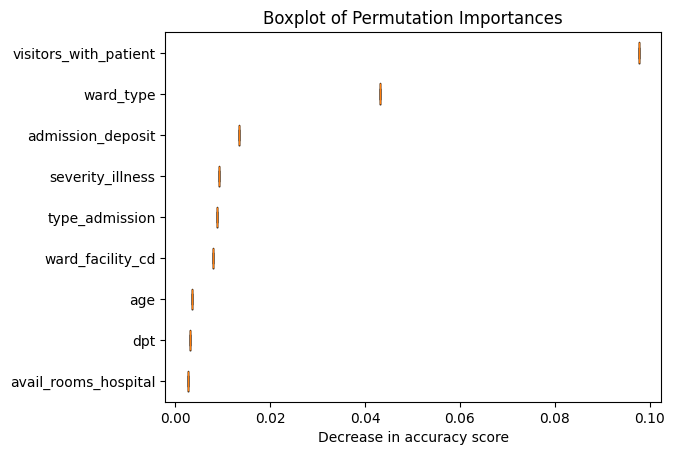

In [ ]:
# Plot permutation importance
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[perm_sorted_idx].T, vert=False, tick_labels=X_train.columns[perm_sorted_idx])
plt.xlabel("Decrease in accuracy score")
plt.title("Boxplot of Permutation Importances")
plt.show()

In [ ]:
# Remove features with permutation importance below threshold
threshold = 0.0
drop_cols = []

for importance,col in zip(result.importances[perm_sorted_idx].T,X_train.columns[perm_sorted_idx]): # check importance of each feature
    
    # add to drop list if mean importance approx equal to 0
    if np.round(np.mean(importance),2) <= threshold:
        drop_cols += [col]

df_clean.drop(drop_cols, axis=1, inplace=True)       
print("Columns with permutation importance below threshold: ",drop_cols)

## 3. Predictive Analysis

* View class distribution

In [ ]:
df['stay'].value_counts().plot(kind='bar', figsize=(7, 5))
plt.title('Distribution of Stay Categories')
plt.xlabel('Stay Category')
plt.ylabel('Count')
plt.show()

KeyError: 'stay'

* Define the predictive Models


   Random Forest - 
      Ensemble learning methods using multiple decision trees and a "voting" approach. Tends to be robust to noise, handles high dimensional data and imbalanced datasets. However, can be computationally expensive depending on dataset size.

   XGBoost - Ensemble boosting method using multiple trees. Scales well to large dataset and is interpretable.

   Dummy Classifier (Stratified) - 
      Predicts the class based on the training sets class distribution. This trivial classifier is used as a baseline to compare the Random Forest model with.

In [ ]:
# Define class weights to make model more sensitive to minority class
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=df_clean["stay"]
)

# Define models
DUM = DummyClassifier(strategy="stratified", random_state=42)
RF  = RandomForestClassifier(class_weight='balanced_subsample', criterion='gini', random_state=42)
XGB = XGBClassifier(objective='multi:softmax', num_class=df_clean["stay"].nunique(),learning_rate=0.1, random_state=42, scale_pos_weight=classes_weights)
OvR_XGB = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_jobs=-1, scale_pos_weight=classes_weights))


# Define Hyperparameters for each model
models = ["RF", "XGB", "OvR_XGB"]                                       # list of ML models to train using nested CV
max_depth    = [3, 6, 9]                                              # max depth of trees

training_dict={                                                         # a dictionary to store the hyperparameters to consider for each model
    "RF": {
        "model": RF,
        "hyperparams":{
            "max_depth": max_depth
            }
    },
    "XGB": {
        "model": XGB,
        "hyperparams":{
            "max_depth": max_depth
            }
    },
    "OvR_XGB": {
        "model": OvR_XGB,
        "hyperparams":{
            "estimator__max_depth": max_depth
            }
    }
}

* Random Forest: Train and Cross Validate

    Perform nested cross validation to tune model and validate model performance. This is done to avoid overfitting due to data leakage during hyperparameter tuning and validation in order to make a better comparison between models and choose the most suitable one. (see https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)

In [ ]:
# Define data
X=df_clean.drop(["stay"], axis=1)
y=df_clean["stay"]

# Define cross valiation
splits_outer = 2
splits_inner = 2
outer_cv = StratifiedKFold(n_splits=splits_outer , shuffle=True, random_state=1)  # validation of performance

# Perform nested cross validation
nested_results = {}		# store results from each model
Y_test = {}				# store y test values

for model in models: 														# for each ML model
	print(model)
	for i, (train_idx, test_idx) in enumerate(outer_cv.split(X,y)):			# for each outer cross validation set
     
		# split into test and training sets
		X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
		y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
	
		# define hyperparam cross-validation procedure
		inner_cv = StratifiedKFold(n_splits=splits_inner, shuffle=True, random_state=1) # hyperparameter optimisation
	
		# execute cross validated grid search for model
		grid_search = GridSearchCV(training_dict[model]["model"], training_dict[model]["hyperparams"], scoring='balanced_accuracy', cv=inner_cv, refit=True)
		grid_search_result = grid_search.fit(X_train, y_train)
	
		# get the best grid search model
		best_model = grid_search_result.best_estimator_
	
		# evaluate best model on the hold out dataset
		y_pred = best_model.predict(X_test)

		# save results
		nested_results[model +"_" +str(i)] =  {
      		"predictions": y_pred.tolist(),
			"grid_search_best_score": float(grid_search_result.best_score_),
			"grid_search_best_params":grid_search_result.best_params_
			}

  
		if model == models[0]:
			Y_test[str(i)] = y_test

		# report progress
		print('bal. acc=%.3f, est=%.3f, cfg=%s' % (balanced_accuracy_score(y_test, y_pred), grid_search_result.best_score_, grid_search_result.best_params_))
 

RF
(156897,) (156897,)
acc=0.207, est=0.204, cfg={'n_estimators': 100}
(156896,) (156896,)
acc=0.208, est=0.206, cfg={'n_estimators': 200}
XGB
(156897,) (156897,)
acc=0.233, est=0.230, cfg={'n_estimators': 200}
(156896,) (156896,)
acc=0.233, est=0.231, cfg={'n_estimators': 200}
OvR_XGB


ValueError: Invalid parameter 'n_estimators' for estimator OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=None, ...)). Valid parameters are: ['estimator', 'n_jobs', 'verbose'].

In [ ]:
import json

# Save nested cross validation data to json
RESULTS_PATH = os.path.join(DIR,"results","Nested_CV_Data.json")

with open(RESULTS_PATH, "w") as outfile: 
    json.dump(nested_results, outfile)

* Dummy Classifier Cross Validate

In [ ]:
# DUM: Perform cross validation
DUM_results = {}
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X,y)):
	# test train split
	X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
	y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
 
	# fit dummy classifier
	DUM.fit(X_train, y_train)
	y_pred = DUM.predict(X_test)
 
	# get metrics
	DUM_results[i]  = {"predictions": y_pred.tolist()}


In [ ]:
# save dummy results to json file
RESULTS_PATH = os.path.join(DIR,"results","DUM_CV_Data.json")

with open(RESULTS_PATH, "w") as outfile: 
    json.dump(DUM_results, outfile)

* Model Selection Using Cross Validation Results

    The mean and standard deviation of the following metrics are considered:
    
            1. Balanced Accuracy - average accuracy for each class
            2. F1-score (macro)  - average f1-score for each class

In [ ]:
bal_acc_results = {}
acc_results = {}
f1_results = {}

# Compute metrics for models
for model in models:  # for each model
    balanced_acc = []
    f1 = []
    acc = []
    for cv_index in range(splits_outer):  # for each outer cross validation split
        
        y_pred = nested_results[model+"_" +str(cv_index)]["predictions"]
        y_test = Y_test[str(cv_index)]
        balanced_acc += [balanced_accuracy_score(y_test, y_pred)]
        f1 += [f1_score(y_test, y_pred, average='macro')]
        acc += [accuracy_score(y_test, y_pred)]
        
        
    # save metrics to dict
    bal_acc_results[model] =  balanced_acc
    f1_results[model]      =  f1
    acc_results[model]     =  acc
    
    
    

In [ ]:
# Compute metrics for dummy classifier
balanced_acc = []
f1 = []
acc = []
for cv_index in range(splits_outer):  # for each outer cross validation split
    y_test = Y_test[str(cv_index)]
    y_pred = DUM_results[cv_index]["predictions"]
    balanced_acc += [balanced_accuracy_score(y_test, y_pred)]
    f1 += [f1_score(y_test, y_pred, average='macro')]
    acc += [accuracy_score(y_test, y_pred)]
    
# save metrics to dict
bal_acc_results["DUM"] =  balanced_acc
f1_results["DUM"]      =  f1
acc_results["DUM"]     =  acc
    

In [ ]:
acc_results

{'RF': [0.30371517619839766, 0.3029459004691005],
 'XGB': [0.3996953415297934, 0.39716117683051194],
 'OvR_XGB': [0.3947685424195491, 0.393789516622476],
 'DUM': [0.18846121978113028, 0.18846242096675506]}

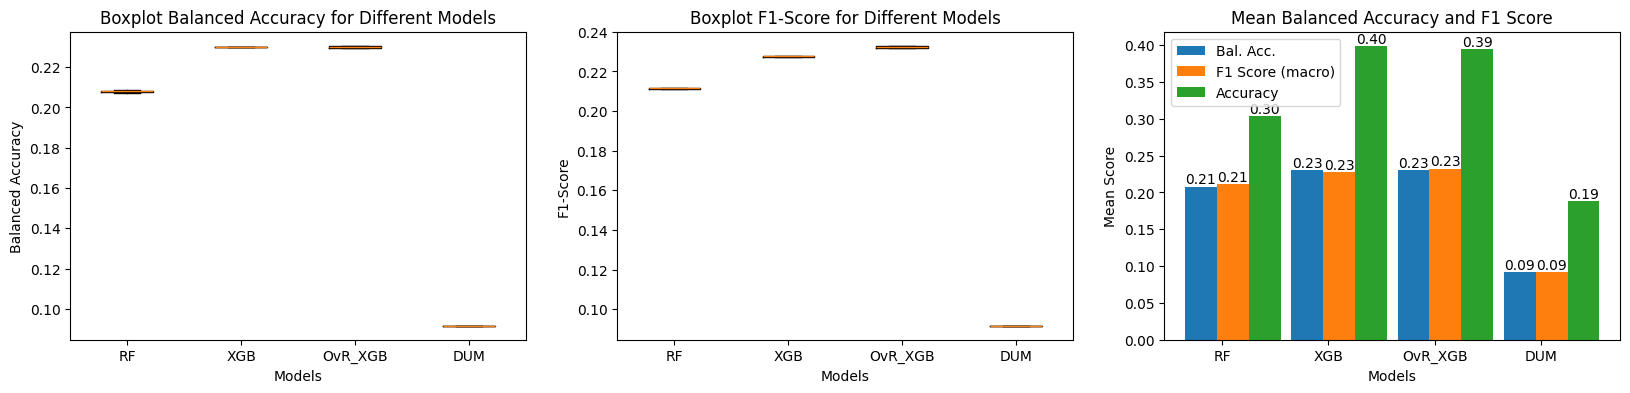

In [ ]:
# Create Box-plots
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
# axs[0].boxplot(bal_acc_results.values(), tick_labels=bal_acc_results.keys())
# axs[0].set_title("Boxplot Balanced Accuracy for Different Models")
# axs[0].set_xlabel("Models")
# axs[0].set_ylabel("Balanced Accuracy")

# axs[1].boxplot(f1_results.values(), tick_labels=f1_results.keys())
# axs[1].set_title("Boxplot F1-Score for Different Models")
# axs[1].set_xlabel("Models")
# axs[1].set_ylabel("F1-Score")

# Compute mean values for each dictionary
bal_acc_means = {key: np.mean(value) for key, value in bal_acc_results.items()}
f1_means = {key: np.mean(value) for key, value in f1_results.items()}
acc_means = {key: np.mean(value) for key, value in acc_results.items()}

# Compute standard deviation for each dictionary
bal_acc_std = {key: np.std(value) for key, value in bal_acc_results.items()}
f1_std = {key: np.std(value) for key, value in f1_results.items()}
acc_std = {key: np.std(value) for key, value in acc_results.items()}

# Bar chart plotting
labels = list(bal_acc_means.keys())
bal_acc_values = list(bal_acc_means.values())
f1_values = list(f1_means.values())
acc_values = list(acc_means.values())

x = np.arange(len(labels))  # Label locations

a = axs[0].errorbar(x, bal_acc_values, yerr=bal_acc_std, width=0.3, label='Bal. Acc.')
b = axs[0].errorbar(x +0.3, f1_values, yerr=f1_std, width=0.3, label='F1 Score (macro)')
c = axs[0].errorbar(x + 0.6, acc_values, yerr=acc_std, width=0.3, label='Accuracy')
axs[0].bar_label(a, fmt='%.2f', label_type='edge')
axs[0].bar_label(b, fmt='%.2f', label_type='edge')
axs[0].bar_label(c, fmt='%.2f', label_type='edge')
axs[0].set_title("Mean Balanced Accuracy and F1 Score")
axs[0].set_xlabel("Models")
axs[0].set_ylabel("Mean Score")
axs[0].set_xticks(x+0.2,models+["DUM"])
axs[0].legend()

plt.show()

The XXX model shows the best performance. However, ..... resampling dataset or using 

* Hyper Parameter Tuning for best model
  

In [ ]:
# Define Hyperparameters for each model
n_est     = [100, 150]                                              # number of trees
max_depth = [4]
model = "OvR_XGB"
training_dict={                                                         # a dictionary to store the hyperparameters to consider for each model
    model : {
        "model": OvR_XGB,
        "hyperparams":{
            "estimator__n_estimators": n_est,
            #"max_depth": max_depth
            }
    }
}


# define hyperparam cross-validation procedure
inner_cv = StratifiedKFold(n_splits=splits_inner, shuffle=True, random_state=1) # hyperparameter optimisation

# execute cross validated grid search for model
grid_search = GridSearchCV(training_dict[model]["model"], training_dict[model]["hyperparams"], scoring='balanced_accuracy', cv=inner_cv, refit=True)
grid_search_result = grid_search.fit(X_train, y_train)

# get the best grid search model
best_model = grid_search_result.best_estimator_

# evaluate best model on the hold out dataset
y_pred = best_model.predict(X_test)

# report result
print('balanced acc=%.3f, f1 score=%.3f, cfg=%s' % (balanced_accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro'),grid_search_result.best_params_))


ValueError: Invalid parameter 'n_estimators' for estimator OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=None, ...)). Valid parameters are: ['estimator', 'n_jobs', 'verbose'].

The performance is also evaluated using a confusion matrix to better understand the predictive performance for each class.

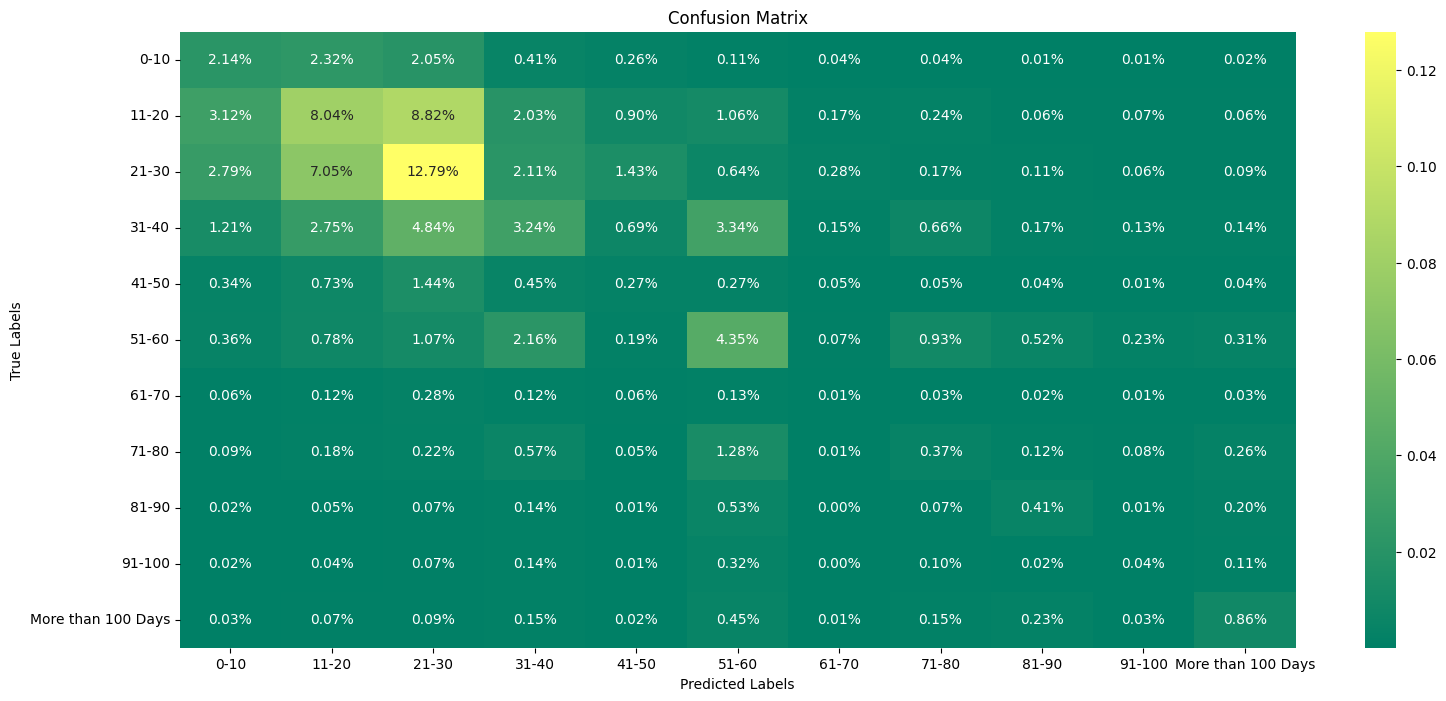

In [ ]:
stay_mapping = dict(zip(stay_enc.classes_, stay_enc.transform(stay_enc.classes_)))
conf_matrix = confusion_matrix(y_test, y_pred)
               
plt.figure(figsize = (18,8))
sns.heatmap(conf_matrix/np.sum(conf_matrix), fmt='.2%', annot = True, xticklabels = stay_mapping.keys(), yticklabels = stay_mapping.keys(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
per_class_performance = conf_matrix.diagonal()/conf_matrix.sum(axis=1)

## 4. Prescriptive Analysis

## 5. Transparency & Explainability